Machine Learning: Predicting Trade Flows

【Step 1/5】Loading raw data...
Successfully loaded trade data: 24025656 records, covering years [2016, 2017, 2018]
Successfully loaded GDP data: 594 records, covering 198 countries
Successfully loaded shapefile: centroid coordinates for 186 countries
 Visualization figure saved to: ./visualizations-12.7（3）/03_country_centroid_dist.png

【Step 2/5】Constructing panel data...
After aggregating trade data: 79653 (t,i,j) records
Final panel data: 66306 valid records (missing values removed)
 Visualization figure saved to: ./visualizations-12.7（3）/06_v_total_distribution_comparison.png
 Visualization figure saved to: ./visualizations-12.7（3）/07_distance_distribution.png

【Step 3/5】Training Random Forest model (including hyperparameter tuning)...

Training set: 44794 records | Test set: 21512 records
Feature list: ['log_gdp_exporter', 'log_gdp_importer', 'log_distance_km']
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
CV cross-validation average R²: 0.7155
Full training set R² (log scale): 0.9547
Full training set R² (original export value scale): 0.9624
 Visualization figure saved to: ./visualizations-12.7（3）/08_hyperparam_tuning_heatmap.png

Training set prediction examples (first 5 records):
   Actual Value (1000 USD)  Predicted Value (1000 USD)
0                    46.18                       76.85
1                   331.85                      136.43
2                    16.55                       28.85
3                   212.28                      478.89
4                   421.47                      337.44
 Visualization figure saved to: ./visualizations-12.7（3）/09_train_pred_scatter.png

【Step 4/5】Evaluating model performance + saving prediction results...

Model Test Set Evaluation Results (Original Scale: 1000 USD)
Mean Absolute Error (MAE): 287880.99 1000 USD
Mean Squared Error (MSE): 4425665570118.

/var/folders/60/7wzhkhj57jd8d8qg30h2zy9m0000gn/T/ipykernel_57498/651610989.py:462: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenarios, y=values, ax=ax, palette=["royalblue", "lightcoral"])


 Visualization figure saved to: ./visualizations-12.7（3）/13_china_usa_counterfactual_comparison.png

All processes completed!
Output file list:
1. Visualization figures: ./visualizations-12.7（3）
2. Bilateral trade prediction results: ./bilateral_trade_prediction.csv


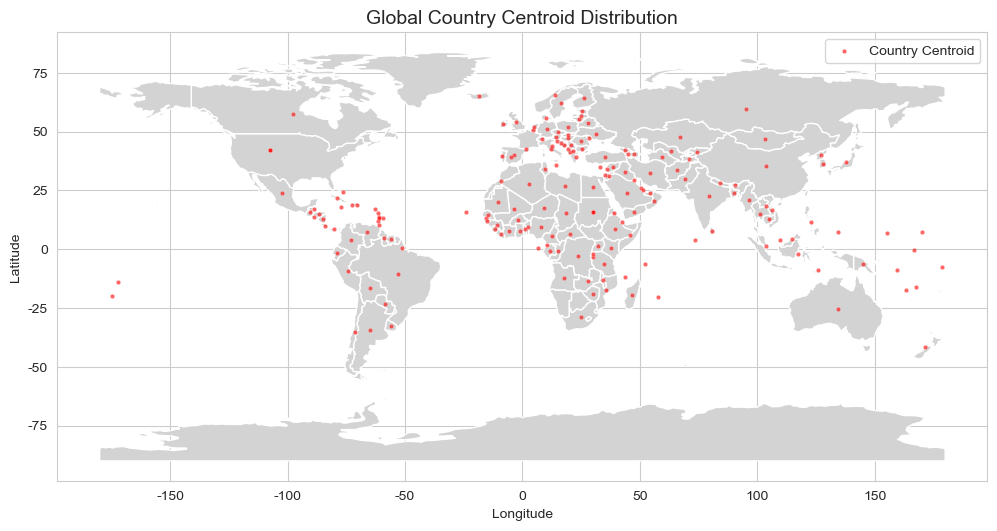

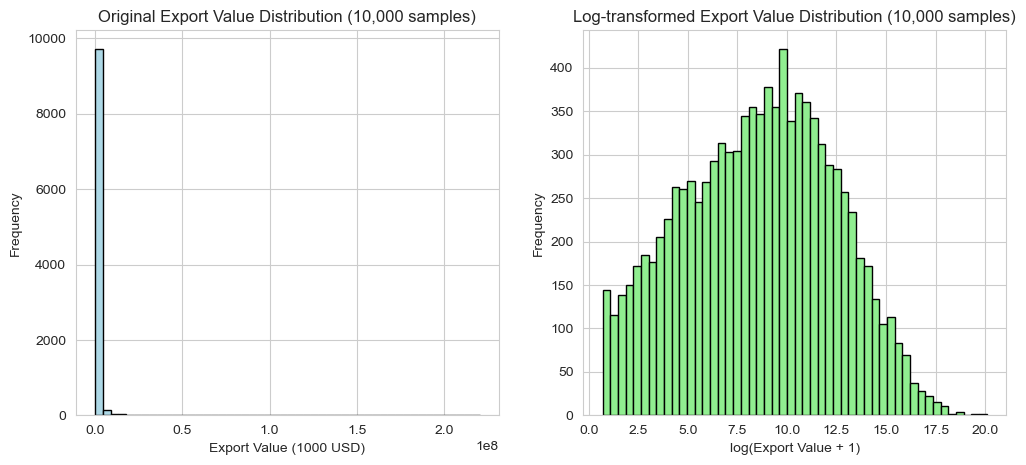

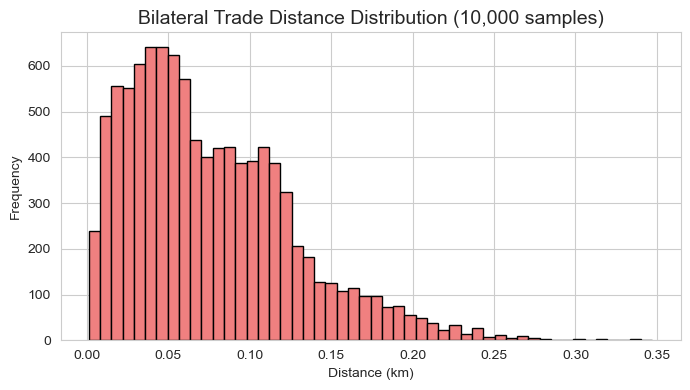

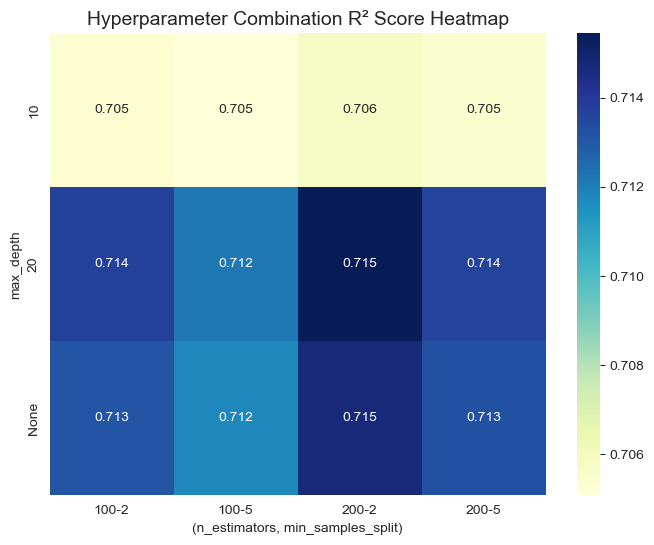

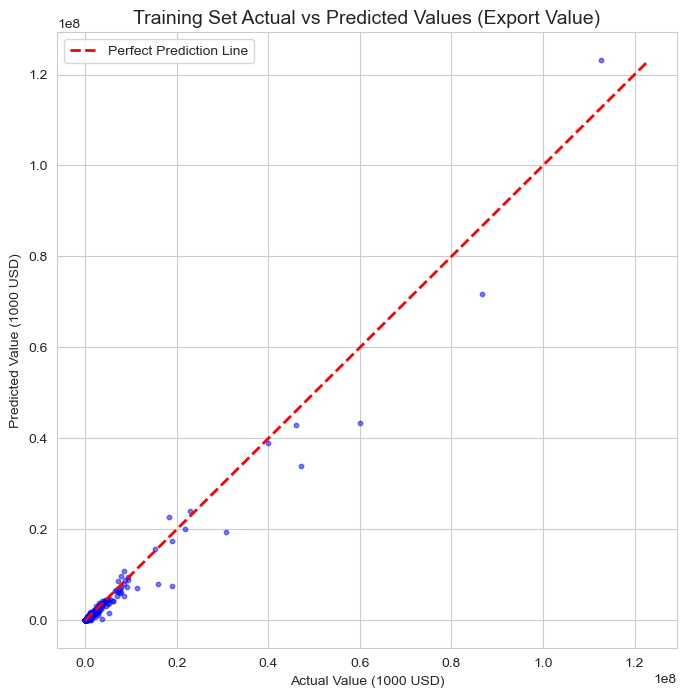

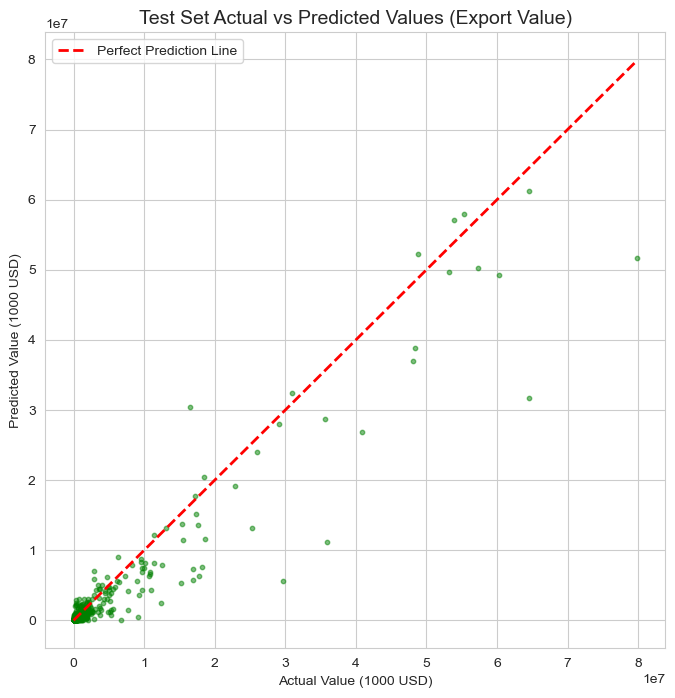

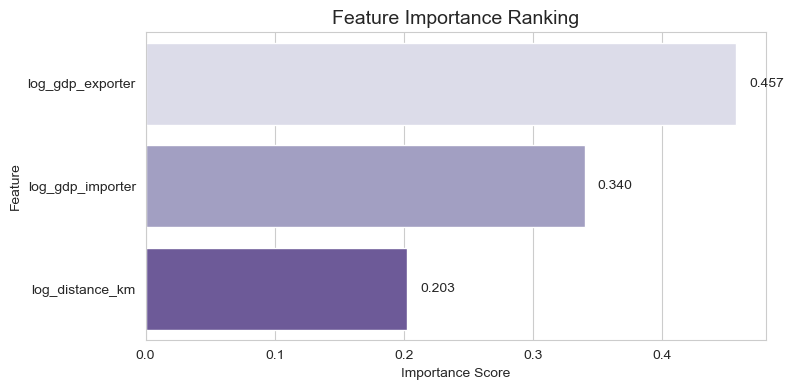

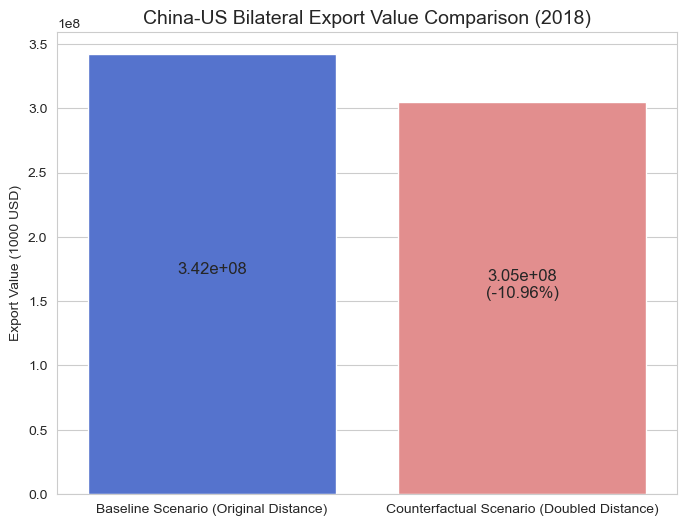

In [25]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings("ignore", category=DataConversionWarning) 
sns.set_style("whitegrid") 
plt.rcParams["axes.unicode_minus"] = False  


# ------------------------------------------------------------------------------
# 1. Configure file paths
# ------------------------------------------------------------------------------
TRADE_DATA_DIR = r"trade data"  
SHAPEFILE_DIR = r"countries_shapefile"  
GDP_FILE_PATH = r"API_NY.GDP.MKTP.CD_DS2_en_csv_v2_216063.csv"  
COUNTRY_CODES_PATH = r"trade data/country_codes_V202001.csv"  
TARGET_YEARS = [2016, 2017, 2018]
CHINA_ISO = 156  
USA_ISO = 842  

VISUAL_DIR = "./visualizations-12.7（3）"
if not os.path.exists(VISUAL_DIR):
    os.makedirs(VISUAL_DIR)

def save_fig(fig, filename):
    """Save figure to specified directory"""
    fig_path = os.path.join(VISUAL_DIR, filename)
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    print(f" Visualization figure saved to: {fig_path}")


# ------------------------------------------------------------------------------
# 2. Data loading functions
# ------------------------------------------------------------------------------
def load_trade_data(trade_dir, target_years):
    """Load and merge HS6-level trade data for target years"""
    trade_dfs = []
    for year in target_years:
        file_name = f"BACI_HS12_Y{year}_V202001.csv"
        file_path = os.path.join(trade_dir, file_name)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Trade data file missing: {file_path}")
        df = pd.read_csv(file_path)
        df["k"] = df["k"].astype(str).str.zfill(6)
        df["t"] = year
        trade_dfs.append(df)

    all_trade = pd.concat(trade_dfs, ignore_index=True)
    print(f"Successfully loaded trade data: {len(all_trade)} records, covering years {target_years}")
    return all_trade


def load_gdp_data(gdp_file_path, target_years, country_codes_path):
    """Load World Bank GDP data"""
    # Load country code mapping
    country_codes = pd.read_csv(country_codes_path, encoding='Latin-1')
    required_cols = ["country_name_full", "iso_3digit_alpha", "country_code"]
    if not all(col in country_codes.columns for col in required_cols):
        raise ValueError(f"Country code file must contain columns: {required_cols}")
    country_codes = country_codes[required_cols].dropna()
    country_codes["country_code"] = country_codes["country_code"].astype(int)

    # Load GDP data
    gdp_raw = pd.read_csv(gdp_file_path, skiprows=4)
    gdp_cols = ["Country Name", "Country Code"] + [str(year) for year in target_years]
    gdp_raw = gdp_raw[gdp_cols].dropna(subset=["Country Code"])

    # Reshape data
    gdp_long = pd.melt(
        gdp_raw,
        id_vars=["Country Name", "Country Code"],
        value_vars=[str(year) for year in target_years],
        var_name="year",
        value_name="gdp"
    )
    gdp_long["year"] = gdp_long["year"].astype(int)
    gdp_long["gdp"] = pd.to_numeric(gdp_long["gdp"], errors="coerce")

    # Merge country codes
    gdp_long = gdp_long.merge(
        country_codes,
        left_on="Country Code",
        right_on="iso_3digit_alpha",
        how="left"
    )
    gdp_final = gdp_long[["country_code", "year", "gdp"]].dropna()
    gdp_final.rename(columns={"country_code": "country_iso", "year": "t"}, inplace=True)
    print(f"Successfully loaded GDP data: {len(gdp_final)} records, covering {len(gdp_final['country_iso'].unique())} countries")
    return gdp_final


def load_shapefile(shapefile_dir, country_codes_path):
    """Load country shapefile + visualize centroid distribution"""
    # Load shapefile
    shp_files = [f for f in os.listdir(shapefile_dir) if f.endswith(".shp")]
    if not shp_files:
        raise FileNotFoundError(f"No .shp files found in shapefile directory: {shapefile_dir}")
    shp_path = os.path.join(shapefile_dir, shp_files[0])
    gdf = gpd.read_file(shp_path)
    gdf = gdf.to_crs(epsg=4326)

    # Fix centroid warning: convert to projected CRS first to calculate centroid
    gdf_proj = gdf.to_crs(epsg=6933)  # Equal area projected CRS
    gdf_proj["centroid_proj"] = gdf_proj.centroid
    gdf["centroid"] = gdf_proj["centroid_proj"].to_crs(epsg=4326)  # Convert back to WGS84
    
    # Extract latitude and longitude
    gdf["lat"] = gdf["centroid"].y
    gdf["lon"] = gdf["centroid"].x

    # Merge country codes
    country_codes = pd.read_csv(country_codes_path, encoding='Latin-1')[["iso_3digit_alpha", "country_code"]].dropna()
    country_codes["country_code"] = country_codes["country_code"].astype(int)
    shapefile_iso3_col = "ADM0_A3"
    if shapefile_iso3_col not in gdf.columns:
        raise ValueError(f"Shapefile missing '{shapefile_iso3_col}' field")
    gdf_with_iso = gdf.merge(
        country_codes,
        left_on=shapefile_iso3_col,
        right_on="iso_3digit_alpha",
        how="left"
    ).dropna(subset=["country_code"])
    centroid_df = gdf_with_iso[["country_code", "lat", "lon"]].drop_duplicates("country_code")

    print(f"Successfully loaded shapefile: centroid coordinates for {len(centroid_df)} countries")

    # Visualize centroid distribution on world map
    fig, ax = plt.subplots(figsize=(12, 6))
    # Plot world map base layer
    world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
    world.plot(ax=ax, color="lightgray", edgecolor="white")
    # Plot country centroids
    sns.scatterplot(x="lon", y="lat", data=centroid_df, ax=ax, 
                    s=10, color="red", alpha=0.6, label="Country Centroid")
    ax.set_title("Global Country Centroid Distribution", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    save_fig(fig, "03_country_centroid_dist.png")

    return centroid_df


# ------------------------------------------------------------------------------
# 3. Panel data construction
# ------------------------------------------------------------------------------
def build_panel_data(trade_data, gdp_data, centroid_df):
    """Construct panel data"""
    # 1. Aggregate trade data
    panel_raw = trade_data.groupby(["t", "i", "j"])["v"].sum().reset_index()
    panel_raw.rename(columns={"v": "v_total"}, inplace=True)
    print(f"After aggregating trade data: {len(panel_raw)} (t,i,j) records")

    # 2. Merge features
    panel = panel_raw.merge(
        gdp_data, left_on=["i", "t"], right_on=["country_iso", "t"], how="left"
    ).rename(columns={"gdp": "gdp_exporter"}).drop("country_iso", axis=1)
    panel = panel.merge(
        gdp_data, left_on=["j", "t"], right_on=["country_iso", "t"], how="left"
    ).rename(columns={"gdp": "gdp_importer"}).drop("country_iso", axis=1)
    panel = panel.merge(
        centroid_df, left_on="i", right_on="country_code", how="left"
    ).rename(columns={"lat": "lat_exporter", "lon": "lon_exporter"}).drop("country_code", axis=1)
    panel = panel.merge(
        centroid_df, left_on="j", right_on="country_code", how="left"
    ).rename(columns={"lat": "lat_importer", "lon": "lon_importer"}).drop("country_code", axis=1)

    # 3. Calculate distance
    def calc_geopandas_distance(row):
        try:
            exp_point = gpd.points_from_xy([row["lon_exporter"]], [row["lat_exporter"]])[0]
            imp_point = gpd.points_from_xy([row["lon_importer"]], [row["lat_importer"]])[0]
            return exp_point.distance(imp_point) / 1000
        except:
            return np.nan
    panel["distance_km"] = panel.apply(calc_geopandas_distance, axis=1)

    # 4. Handle missing values
    # Visualize missing value distribution
    panel = panel.dropna(subset=["gdp_exporter", "gdp_importer", "distance_km", "v_total"]).reset_index(drop=True)
    print(f"Final panel data: {len(panel)} valid records (missing values removed)")

    # 5. Log transformation + distribution visualization
    panel["log_v_total"] = np.log1p(panel["v_total"])
    panel["log_gdp_exporter"] = np.log1p(panel["gdp_exporter"])
    panel["log_gdp_importer"] = np.log1p(panel["gdp_importer"])
    panel["log_distance_km"] = np.log1p(panel["distance_km"])

    # Compare original vs log-transformed export value distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Original distribution
    axes[0].hist(panel["v_total"].sample(10000), bins=50, color="lightblue", edgecolor="black")
    axes[0].set_title("Original Export Value Distribution (10,000 samples)", fontsize=12)
    axes[0].set_xlabel("Export Value (1000 USD)")
    axes[0].set_ylabel("Frequency")
    axes[0].ticklabel_format(style="scientific", axis="x", scilimits=(0,0))
    # Log-transformed distribution
    axes[1].hist(panel["log_v_total"].sample(10000), bins=50, color="lightgreen", edgecolor="black")
    axes[1].set_title("Log-transformed Export Value Distribution (10,000 samples)", fontsize=12)
    axes[1].set_xlabel("log(Export Value + 1)")
    axes[1].set_ylabel("Frequency")
    save_fig(fig, "06_v_total_distribution_comparison.png")

    # Visualize bilateral distance distribution
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(panel["distance_km"].sample(10000), bins=50, color="lightcoral", edgecolor="black")
    ax.set_title("Bilateral Trade Distance Distribution (10,000 samples)", fontsize=14)
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Frequency")
    save_fig(fig, "07_distance_distribution.png")

    return panel


# ------------------------------------------------------------------------------
# 4. Model training
# ------------------------------------------------------------------------------
def train_rf_model(panel_data):
    """Train Random Forest model + visualize hyperparameter tuning/prediction results"""
    # Reset indices for train/test sets
    train = panel_data[panel_data["t"].isin([2016, 2017])].reset_index(drop=True)
    test = panel_data[panel_data["t"] == 2018].reset_index(drop=True)
    
    feature_cols = ["log_gdp_exporter", "log_gdp_importer", "log_distance_km"]
    X_train = train[feature_cols]
    y_train = train["log_v_total"] 
    X_test = test[feature_cols]
    y_test = test["log_v_total"]
    test_meta = test[["t", "i", "j", "v_total"]].reset_index(drop=True)

    print(f"\nTraining set: {len(X_train)} records | Test set: {len(X_test)} records")
    print(f"Feature list: {feature_cols}")

    # Hyperparameter tuning
    rf_base = RandomForestRegressor(random_state=42, n_jobs=4)
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5]
    }
    grid_search = GridSearchCV(
        estimator=rf_base, param_grid=param_grid, cv=3, scoring="r2", verbose=1, n_jobs=4
    )
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    print(f"\nBest hyperparameters: {grid_search.best_params_}")
    print(f"CV cross-validation average R²: {grid_search.best_score_:.4f}")

    # ----------------------Calculate full training set R² ----------------------
    # 1. Full training set R² (log scale)
    y_train_pred_log = best_rf.predict(X_train) 
    train_r2_log = r2_score(y_train, y_train_pred_log)  
    
    # 2. Full training set R² (original export value scale)
    y_train_original = np.expm1(y_train) 
    y_train_pred_original = np.expm1(y_train_pred_log) 
    train_r2_original = r2_score(y_train_original, y_train_pred_original) 
    
    # Print full R² results
    print(f"Full training set R² (log scale): {train_r2_log:.4f}")
    print(f"Full training set R² (original export value scale): {train_r2_original:.4f}")
    # ----------------------------------------------------------------------

    # Visualize hyperparameter tuning results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results["param_max_depth"] = cv_results["param_max_depth"].astype(str)
    cv_pivot = cv_results.pivot_table(
        values="mean_test_score", 
        index="param_max_depth", 
        columns=["param_n_estimators", "param_min_samples_split"]
    )
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cv_pivot, annot=True, cmap="YlGnBu", fmt=".3f", ax=ax)
    ax.set_title("Hyperparameter Combination R² Score Heatmap", fontsize=14)
    ax.set_xlabel("(n_estimators, min_samples_split)")
    ax.set_ylabel("max_depth")
    save_fig(fig, "08_hyperparam_tuning_heatmap.png")

    # Training set prediction example (original scale)
    print(f"\nTraining set prediction examples (first 5 records):")
    train_pred_sample = pd.DataFrame({
        "Actual Value (1000 USD)": y_train_original.head(5).values, 
        "Predicted Value (1000 USD)": y_train_pred_original[:5]
    })
    print(train_pred_sample.round(2))

    # Add: Training set actual vs predicted value scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sample_idx = np.random.choice(len(y_train), size=2000, replace=False) 
    ax.scatter(
        y_train_original.iloc[sample_idx], 
        y_train_pred_original[sample_idx], 
        alpha=0.5, s=10, color="blue"
    )
    min_val = min(y_train_original.iloc[sample_idx].min(), y_train_pred_original[sample_idx].min())
    max_val = max(y_train_original.iloc[sample_idx].max(), y_train_pred_original[sample_idx].max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2, label="Perfect Prediction Line")
    ax.set_title("Training Set Actual vs Predicted Values (Export Value)", fontsize=14)
    ax.set_xlabel("Actual Value (1000 USD)")
    ax.set_ylabel("Predicted Value (1000 USD)")
    ax.legend()
    ax.ticklabel_format(style="scientific", axis="both", scilimits=(0,0))
    save_fig(fig, "09_train_pred_scatter.png")

    return best_rf, X_train, y_train, X_test, y_test, feature_cols, test_meta


# ------------------------------------------------------------------------------
# 5. Model evaluation
# ------------------------------------------------------------------------------
def evaluate_model(model, X_test, y_test, feature_cols, test_meta):
    """Evaluate model performance"""
    # Predict
    y_pred_log = model.predict(X_test)
    y_test_original = np.expm1(y_test)
    y_pred_original = np.expm1(y_pred_log)

    assert len(test_meta) == len(y_pred_original), f"test_meta length ({len(test_meta)}) does not match prediction result length ({len(y_pred_original)})!"

    # Calculate metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    print("\n" + "=" * 50)
    print("Model Test Set Evaluation Results (Original Scale: 1000 USD)")
    print("=" * 50)
    print(f"Mean Absolute Error (MAE): {mae:.2f} 1000 USD")
    print(f"Mean Squared Error (MSE): {mse:.2f} (1000 USD)²")
    print(f"Coefficient of Determination (R²): {r2:.4f}")
    print("=" * 50)

    # Test set actual vs predicted value scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sample_idx = np.random.choice(len(y_test), size=2000, replace=False)
    ax.scatter(
        y_test_original.iloc[sample_idx], 
        y_pred_original[sample_idx], 
        alpha=0.5, s=10, color="green"
    )
    min_val = min(y_test_original.iloc[sample_idx].min(), y_pred_original[sample_idx].min())
    max_val = max(y_test_original.iloc[sample_idx].max(), y_pred_original[sample_idx].max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2, label="Perfect Prediction Line")
    ax.set_title("Test Set Actual vs Predicted Values (Export Value)", fontsize=14)
    ax.set_xlabel("Actual Value (1000 USD)")
    ax.set_ylabel("Predicted Value (1000 USD)")
    ax.legend()
    ax.ticklabel_format(style="scientific", axis="both", scilimits=(0,0))
    save_fig(fig, "10_test_pred_scatter.png")

    # Feature importance
    feature_importance = pd.DataFrame({
        "feature": feature_cols,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x="importance", y="feature", data=feature_importance, ax=ax, hue="feature", palette="Purples", legend=False)
    ax.set_title("Feature Importance Ranking", fontsize=14)
    ax.set_xlabel("Importance Score")
    ax.set_ylabel("Feature")
    for i, v in enumerate(feature_importance["importance"]):
        ax.text(v + 0.01, i, f"{v:.3f}", va="center")
    save_fig(fig, "12_feature_importance.png")

    prediction_result = pd.DataFrame({
        "Year (t)": test_meta["t"],
        "Exporter Country Code (i)": test_meta["i"],
        "Importer Country Code (j)": test_meta["j"],
        "Actual Export Value (1000 USD)": test_meta["v_total"],
        "Predicted Export Value (1000 USD)": y_pred_original.round(2),
        "Absolute Error (1000 USD)": np.abs(y_test_original - y_pred_original).round(2),
        "Relative Error (%)": (np.abs(y_test_original - y_pred_original) / y_test_original * 100).round(2)
    })
    prediction_result.to_csv("./bilateral_trade_prediction.csv", index=False, encoding='utf-8-sig')
    print(f"\n Test set prediction results saved to: ./bilateral_trade_prediction.csv")

    metrics = {"MAE": mae, "MSE": mse, "R²": r2}
    return metrics, y_test_original, y_pred_original, prediction_result


# ------------------------------------------------------------------------------
# 6. Counterfactual analysis
# ------------------------------------------------------------------------------
def counterfactual_analysis(model, panel_data, feature_cols, china_iso=156, usa_iso=842):
    """Counterfactual analysis + visualize China-US trade comparison"""
    print(f"\n【China-US Data Check】Current filter conditions: Exporter i={china_iso} (China), Importer j={usa_iso} (USA)")
    
    usa_842_exists = 842 in panel_data["j"].unique()
    china_to_842 = len(panel_data[(panel_data["i"] == 156) & (panel_data["j"] == 842)])
    print(f"【Verification】Is US code 842 present as importer: {usa_842_exists}")
    print(f"【Verification】Number of export records from China (156) to US (842): {china_to_842}")

    china_all_data = panel_data[panel_data["i"] == china_iso]
    print(f"Number of records with China (i={china_iso}) as exporter in panel data: {len(china_all_data)}")
    if len(china_all_data) > 0:
        print(f"Top 5 importers for China (j): {china_all_data['j'].value_counts().head().to_dict()}")

    usa_import_data = panel_data[panel_data["j"] == usa_iso]
    print(f"Number of records with US (j={usa_iso}) as importer in panel data: {len(usa_import_data)}")
    if len(usa_import_data) > 0:
        print(f"Top 5 exporters to US (i): {usa_import_data['i'].value_counts().head().to_dict()}")

    # Filter China-US data
    temp_2018 = panel_data[(panel_data["i"] == china_iso) & (panel_data["j"] == usa_iso) & (panel_data["t"] == 2018)]
    temp_2017 = panel_data[(panel_data["i"] == china_iso) & (panel_data["j"] == usa_iso) & (panel_data["t"] == 2017)]
    temp_all = panel_data[(panel_data["i"] == china_iso) & (panel_data["j"] == usa_iso)]
    
    if not temp_2018.empty:
        china_us_data = temp_2018.head(1).reset_index(drop=True)  # Force to take only 1 record
        print(f"\nFound 2018 China-US bilateral data: {len(china_us_data)} records (taking first record only)")
    elif not temp_2017.empty:
        china_us_data = temp_2017.head(1).reset_index(drop=True)
        print(f"\nFound 2017 China-US bilateral data: {len(china_us_data)} records (taking first record only)")
    elif not temp_all.empty:
        china_us_data = temp_all.head(1).reset_index(drop=True)
        print(f"\nFound China-US bilateral data for years {temp_all['t'].unique()}: {len(china_us_data)} records (taking first record only)")
    else:
        raise ValueError("No China-US bilateral trade data found, please adjust ISO codes or supplement data")

    # Baseline vs counterfactual prediction
    X_baseline = china_us_data[feature_cols]
    y_baseline_log = model.predict(X_baseline)
    y_baseline_original = np.expm1(y_baseline_log)[0]  

    china_us_counterfactual = china_us_data.copy()
    china_us_counterfactual["log_distance_km"] += np.log(2)
    X_counterfactual = china_us_counterfactual[feature_cols]
    y_counterfactual_log = model.predict(X_counterfactual)
    y_counterfactual_original = np.expm1(y_counterfactual_log)[0] 

    absolute_change = y_counterfactual_original - y_baseline_original
    relative_change = (absolute_change / y_baseline_original) * 100
    print("\n" + "=" * 60)
    print("Counterfactual Analysis Results: Impact of Doubling China-US Bilateral Distance on Export Value")
    print("=" * 60)
    print(f"Analysis Year: {china_us_data['t'].iloc[0]}")
    print(f"Baseline Scenario (Original Distance): {y_baseline_original:.2f} 1000 USD")
    print(f"Counterfactual Scenario (Doubled Distance): {y_counterfactual_original:.2f} 1000 USD")
    print(f"Absolute Change: {absolute_change:.2f} 1000 USD ({'Decrease' if absolute_change < 0 else 'Increase'})")
    print(f"Relative Change: {relative_change:.2f}%")
    print("=" * 60)
    conclusion = "Interpretation: Export value decreases after doubling China-US distance, consistent with gravity model theory (increased distance → higher transportation costs → reduced trade)."
    if abs(relative_change) < 10:
        conclusion += " The decrease magnitude is small, possibly because China-US trade is dominated by high-value, low-weight goods (e.g., electronic products) which are less sensitive to transportation costs."
    else:
        conclusion += " The decrease magnitude is large, indicating that China-US trade is sensitive to geographical distance and transportation costs are an important influencing factor."
    print(f"\n{conclusion}")

    # Visualize China-US export value comparison (baseline vs counterfactual)
    fig, ax = plt.subplots(figsize=(8, 6))
    scenarios = ["Baseline Scenario (Original Distance)", "Counterfactual Scenario (Doubled Distance)"]
    values = [y_baseline_original, y_counterfactual_original]
    sns.barplot(x=scenarios, y=values, ax=ax, palette=["royalblue", "lightcoral"])
    ax.set_title(f"China-US Bilateral Export Value Comparison ({china_us_data['t'].iloc[0]})", fontsize=14)
    ax.set_ylabel("Export Value (1000 USD)")
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0,0))
    ax.text(0, values[0]/2, f"{values[0]:.2e}", ha="center", fontsize=12)
    ax.text(1, values[1]/2, f"{values[1]:.2e}\n({relative_change:.2f}%)", ha="center", fontsize=12)
    save_fig(fig, "13_china_usa_counterfactual_comparison.png")

    return y_baseline_original, y_counterfactual_original, relative_change


# ------------------------------------------------------------------------------
# 7. Main function
# ------------------------------------------------------------------------------
def main():
    print("=" * 70)
    print("Machine Learning: Predicting Trade Flows")
    print("=" * 70)

    try:
        # Step 1: Load raw data
        print("\n【Step 1/5】Loading raw data...")
        trade_data = load_trade_data(TRADE_DATA_DIR, TARGET_YEARS)
        gdp_data = load_gdp_data(GDP_FILE_PATH, TARGET_YEARS, COUNTRY_CODES_PATH)
        centroid_df = load_shapefile(SHAPEFILE_DIR, COUNTRY_CODES_PATH)

        # Step 2: Construct panel data
        print("\n【Step 2/5】Constructing panel data...")
        panel_data = build_panel_data(trade_data, gdp_data, centroid_df)

        # Step 3: Train Random Forest model
        print("\n【Step 3/5】Training Random Forest model (including hyperparameter tuning)...")
        best_rf, X_train, y_train, X_test, y_test, feature_cols, test_meta = train_rf_model(panel_data)

        # Step 4: Evaluate model performance
        print("\n【Step 4/5】Evaluating model performance + saving prediction results...")
        metrics, y_test_original, y_pred_original, prediction_result = evaluate_model(
            best_rf, X_test, y_test, feature_cols, test_meta
        )

        # Step 5: Counterfactual analysis
        print("\n【Step 5/5】Performing counterfactual analysis (doubling China-US distance)...")
        counterfactual_analysis(best_rf, panel_data, feature_cols, CHINA_ISO, USA_ISO)

        print("\n" + "=" * 70)
        print("All processes completed!")
        print("Output file list:")
        print(f"1. Visualization figures: {VISUAL_DIR}")
        print("2. Bilateral trade prediction results: ./bilateral_trade_prediction.csv")
        print("=" * 70)

    except Exception as e:
        print(f"\nExecution error: {str(e)}")
        import traceback
        traceback.print_exc() 
        print("Please check file paths/data integrity/field matching issues!")

if __name__ == "__main__":
    main()